In [1]:
#load simulation data with loadSimDataOneHot
from simDataPreprocessing import loadSimDataOneHot

data, labels = loadSimDataOneHot('/mnt/d/data/MIME_data/simData/dmMIME/seqLen100/fullEpistasis', maxNumSequences=1000000, splittingProbability=3/100, readSize=23)

first round prot1 done
first round prot6 done
first round prot15 done
first round prot 30 done


In [2]:
data.shape, labels.shape

((1808452, 408), (1808452, 1))

In [3]:
#split data into training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=42)

In [4]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1627606, 408), (180846, 408), (1627606, 1), (180846, 1))

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [6]:
#load data into torch tensors
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

In [7]:
#load data into torch datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [8]:
#set model parameters
batch_size = 128
learning_rate = 0.0005
num_epochs = 5
lambda_l1 = 0.00001
size_factor_hidden = 10
bottle_neck_factor = 2/size_factor_hidden

In [9]:
#load data into torch dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
#set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
#set input and output dimensions
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

In [12]:
#define 4 layer neural network with relu activation function and sigmoid output
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #first layer with input_dim input neurons and inputdim*size_factor_hidden output neurons
        self.fc1 = nn.Linear(input_dim, input_dim*size_factor_hidden)
        #second layer with inputdim*size_factor_hidden input neurons and inputdim*size_factor_hidden output neurons
        self.fc2 = nn.Linear(input_dim*size_factor_hidden, input_dim*size_factor_hidden)
        #third layer with inputdim*size_factor_hidden input neurons and inputdim*size_factor_hidden output neurons
        self.fc3 = nn.Linear(input_dim*size_factor_hidden, input_dim*size_factor_hidden)
        #fourth layer with inputdim*size_factor_hidden input neurons and inputdim output neurons
        self.fc4 = nn.Linear(input_dim*size_factor_hidden, int(input_dim*size_factor_hidden*bottle_neck_factor))
        #fifth layer with inputdim input neurons and output_dim output neurons
        self.fc5 = nn.Linear(int(input_dim*size_factor_hidden*bottle_neck_factor), output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        return x



In [13]:
#initialize model
model = Net()
model.to(device)

Net(
  (fc1): Linear(in_features=408, out_features=4080, bias=True)
  (fc2): Linear(in_features=4080, out_features=4080, bias=True)
  (fc3): Linear(in_features=4080, out_features=4080, bias=True)
  (fc4): Linear(in_features=4080, out_features=816, bias=True)
  (fc5): Linear(in_features=816, out_features=1, bias=True)
)

In [14]:
#set loss function and adam optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
#import tqdm notebook for progress bar
from tqdm import tqdm

In [17]:
#train model on gpu and track training and test loss
train_losses = []
test_losses = []

train_error = []
test_error = []

#get error on training and test set
def getError(model, loader):
    error = 0
    model.eval()
    for data, target in tqdm(loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        error += torch.sum(torch.abs(torch.round(output) - target)).item()
    return error/len(loader.dataset)

for epoch in range(num_epochs):
    print('____________________________________________________________________________________________________________________\n'+'Epoch {}/{}'.format(epoch+1, num_epochs))
    train_loss = 0
    test_loss = 0
    model.train()
    #train model on gpu
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        l1_norm = 0
        for param in model.parameters():
            l1_norm += torch.norm(param, 1)
        loss = criterion(output, target) + lambda_l1*l1_norm
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(train_loader))
    model.eval()

    #test model on gpu
    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        l1_norm = 0
        for param in model.parameters():
            l1_norm += torch.norm(param, 1)
        loss = criterion(output, target) + lambda_l1*l1_norm
        test_loss += loss.item()
    test_losses.append(test_loss/len(test_loader))

    #set all parameters close to zero to zero
    for param in model.parameters():
        threshold = 1e-6
        param.data[(param.data < threshold) & (param.data > -threshold)] = 0
    
    #print training and test loss
    print('Training Loss: {:.6f}, Test Loss: {:.6f}'.format(train_loss/len(train_loader), test_loss/len(test_loader)))

    #get error on training and test set
    train_error.append(getError(model, train_loader))
    test_error.append(getError(model, test_loader))

    #print training and test error
    print('Training Error: {:.6f}, Test Error: {:.6f}'.format(train_error[-1], test_error[-1]))

____________________________________________________________________________________________________________________
Epoch 1/5


100%|██████████| 1413/1413 [00:03<00:00, 384.32it/s]


Training Loss: 0.635587, Test Loss: 0.634813


100%|██████████| 1413/1413 [00:02<00:00, 517.80it/s]


Training Error: 0.325925, Test Error: 0.326897
____________________________________________________________________________________________________________________
Epoch 2/5


100%|██████████| 1413/1413 [00:03<00:00, 386.87it/s]


Training Loss: 0.634479, Test Loss: 0.641770


100%|██████████| 1413/1413 [00:02<00:00, 533.87it/s]


Training Error: 0.328175, Test Error: 0.329667
____________________________________________________________________________________________________________________
Epoch 3/5


100%|██████████| 1413/1413 [00:03<00:00, 384.09it/s]


Training Loss: 0.633796, Test Loss: 0.635604


100%|██████████| 1413/1413 [00:02<00:00, 526.75it/s]


Training Error: 0.325579, Test Error: 0.326222
____________________________________________________________________________________________________________________
Epoch 4/5


100%|██████████| 1413/1413 [00:03<00:00, 378.84it/s]


Training Loss: 0.633311, Test Loss: 0.634589


100%|██████████| 1413/1413 [00:02<00:00, 530.94it/s]


Training Error: 0.326395, Test Error: 0.327201
____________________________________________________________________________________________________________________
Epoch 5/5


100%|██████████| 1413/1413 [00:03<00:00, 367.61it/s]


Training Loss: 0.633070, Test Loss: 0.633394


100%|██████████| 1413/1413 [00:02<00:00, 514.32it/s]

Training Error: 0.326020, Test Error: 0.327350


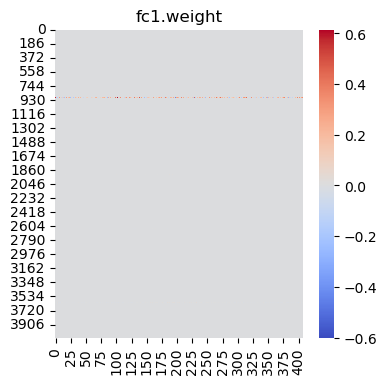

max weight value:  0.6144832
min weight value:  -0.6003274
number of pruned weights:  24336
number of non zero weights:  1640304


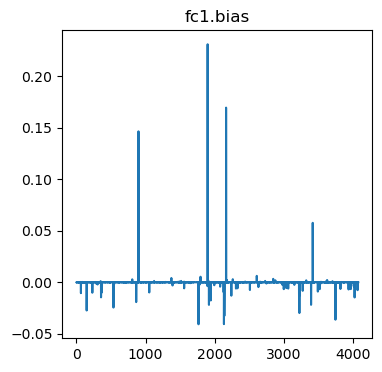

max bias value:  0.231255
min bias value:  -0.040868938
number of pruned biases:  76
number of non zero biases:  4004


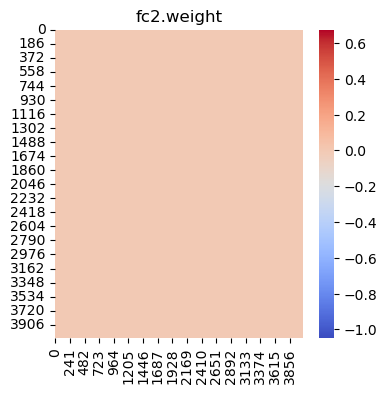

max weight value:  0.6739572
min weight value:  -1.0472952
number of pruned weights:  288732
number of non zero weights:  16357668


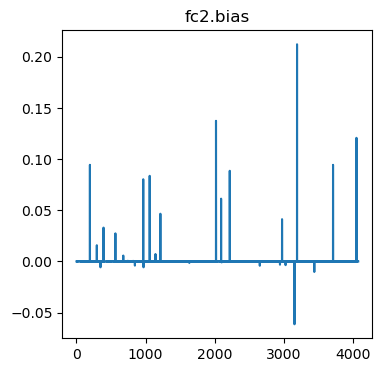

max bias value:  0.21225482
min bias value:  -0.06143682
number of pruned biases:  32
number of non zero biases:  4048


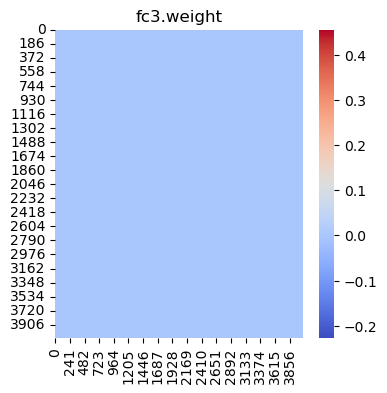

max weight value:  0.45477468
min weight value:  -0.22648068
number of pruned weights:  270225
number of non zero weights:  16376175


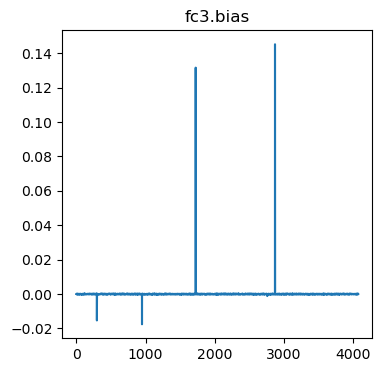

max bias value:  0.14514947
min bias value:  -0.017575115
number of pruned biases:  34
number of non zero biases:  4046


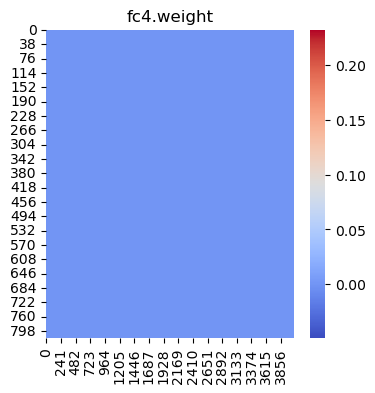

max weight value:  0.23209608
min weight value:  -0.048773807
number of pruned weights:  56365
number of non zero weights:  3272915


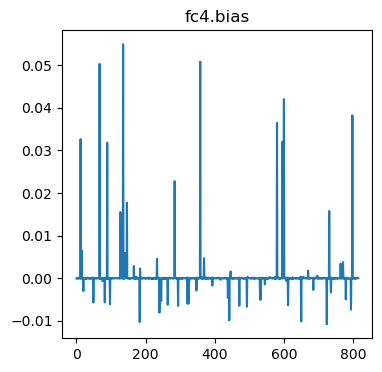

max bias value:  0.05493107
min bias value:  -0.010797531
number of pruned biases:  10
number of non zero biases:  806


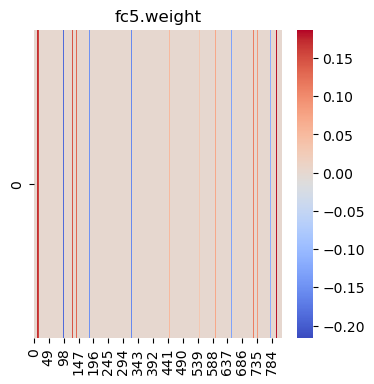

max weight value:  0.1868944
min weight value:  -0.21581613
number of pruned weights:  7
number of non zero weights:  809


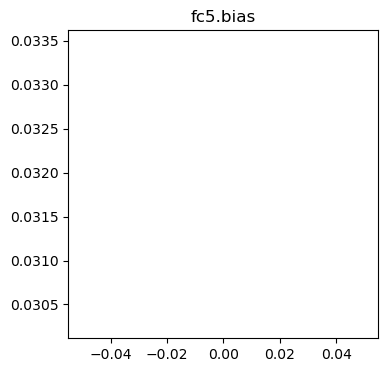

max bias value:  0.031868037
min bias value:  0.031868037
number of pruned biases:  0
number of non zero biases:  1


In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

for name, param in model.named_parameters():
    #if weight is not a bias
    if 'bias' not in name:
        #reshape weights to 2d array
        weight = param.data.cpu().numpy().reshape(param.data.cpu().numpy().shape[0], param.data.cpu().numpy().shape[1])
        #plot heatmap of weights
        plt.figure(figsize=(4,4))
        sns.heatmap(weight, cmap='coolwarm')
        plt.title(name)
        plt.show()

        print('max weight value: ', np.max(weight))
        print('min weight value: ', np.min(weight))
        #print('number of weights: ', weight.size)
        print('number of pruned weights: ', np.sum(weight == 0))
        print('number of non zero weights: ', np.sum(weight != 0))

    else:
        bias = param.data.cpu().numpy()
        #plot histogram of biases
        plt.figure(figsize=(4,4))
        sns.lineplot(bias.flatten())
        plt.title(name)
        plt.show()
 
        print('max bias value: ', np.max(bias))
        print('min bias value: ', np.min(bias))
        #print('number of biases: ', bias.size)
        print('number of pruned biases: ', np.sum(bias == 0))
        print('number of non zero biases: ', np.sum(bias != 0))        

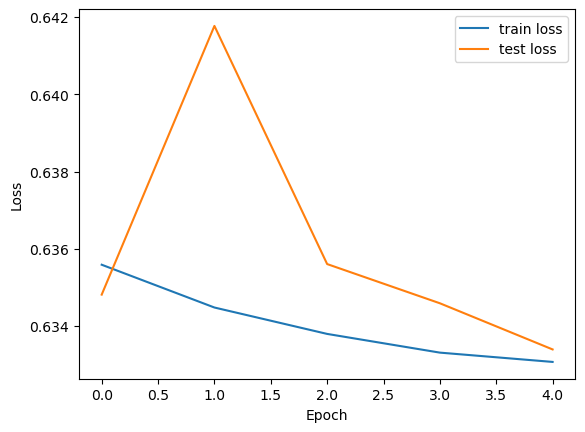

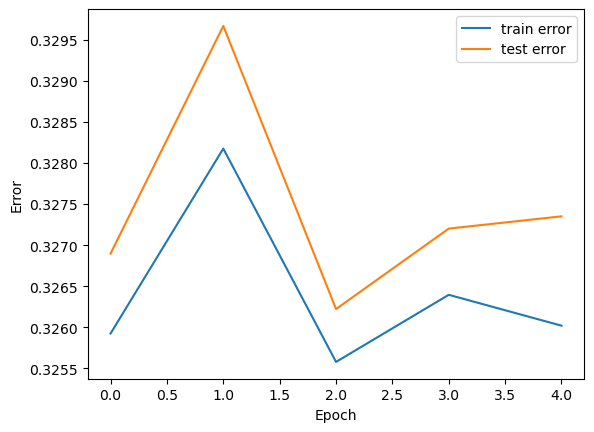

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

#plot training and test loss
sns.lineplot(x= range(len(train_losses)), y=train_losses, label='train loss')
sns.lineplot(x=range(len(test_losses)), y=test_losses, label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#plot training and test error
sns.lineplot(x= range(len(train_error)), y=train_error, label='train error')
sns.lineplot(x=range(len(test_error)), y=test_error, label='test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

100%|██████████| 1413/1413 [00:02<00:00, 546.37it/s]


Training error: 0.32601993357114684
Test error: 0.32735034228017207


100%|██████████| 1413/1413 [00:02<00:00, 547.35it/s]


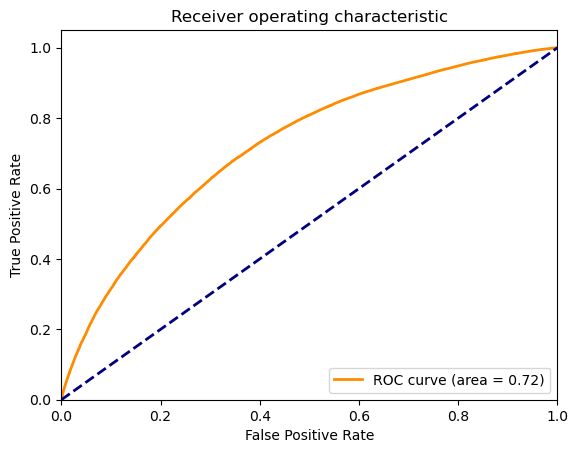

In [20]:
#get error on training and test set
def getError(model, loader):
    error = 0
    model.eval()
    for data, target in tqdm(loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        error += torch.sum(torch.abs(torch.round(output) - target)).item()
    return error/len(loader.dataset)

train_error = getError(model, train_loader)
test_error = getError(model, test_loader)
print('Training error: {}'.format(train_error))
print('Test error: {}'.format(test_error))

#plot roc curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def getRoc(model, loader):
    y_true = []
    y_pred = []
    model.eval()
    for data, target in tqdm(loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        y_true.append(target.cpu().numpy())
        y_pred.append(output.cpu().detach().numpy())
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    return fpr, tpr, thresholds

fpr, tpr, thresholds = getRoc(model, test_loader)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# first checks
bottlenecking the last 2 layers is fine

size_factor_hidden 10/20 no diff

data amount with 50000 results in low variance 

unavoidable error for samples that end up 50/50 in bound/unbound

-> change loss and label to frquencies in pools

In [21]:
import numpy as np

# read in kd values
kds = np.loadtxt('/mnt/d/data/MIME_data/simData/dmMIME/seqLen100/fullEpistasis/secondFromProt1/prot1/single_kds.txt')

#insert 1 at position 0 and then every 3rd position
kds = np.insert(kds, 0, 1)
kds = np.insert(kds, np.arange(4, len(kds), 3), 1)
kds[0:10]

array([1.      , 8.32107 , 1.22316 , 0.434054, 1.      , 0.917788,
       0.292684, 0.228639, 1.      , 6.33962 ])

In [22]:
predictionsZeroConc = []
prediction_example = np.zeros(len(kds)+8)
for i in range(8, len(kds)+8):
    current_prediction_example = prediction_example.copy()
    current_prediction_example[i] = 1
    current_prediction_example = torch.from_numpy(current_prediction_example).float()
    current_prediction_example = current_prediction_example.to(device)
    #output binding probability and append list for given protein concentration combination
    with torch.no_grad():
        output = model(current_prediction_example)
        predictionsZeroConc.append(output.item())

predictionsOneConc = []
prediction_example = np.zeros(len(kds)+8)
for i in range(8, len(kds)+8):
    current_prediction_example = prediction_example.copy()
    current_prediction_example[i] = 1
    current_prediction_example = torch.from_numpy(current_prediction_example).float()
    current_prediction_example = current_prediction_example.to(device)
    #output binding probability and append list for given protein concentration combination
    with torch.no_grad():
        output = model(current_prediction_example)
        predictionsOneConc.append(output.item())

In [23]:
print(len(predictionsZeroConc))
print(len(predictionsOneConc))
print(len(kds))

400
400
400


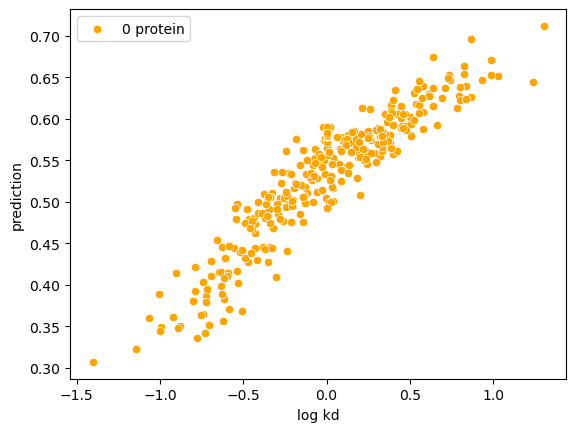

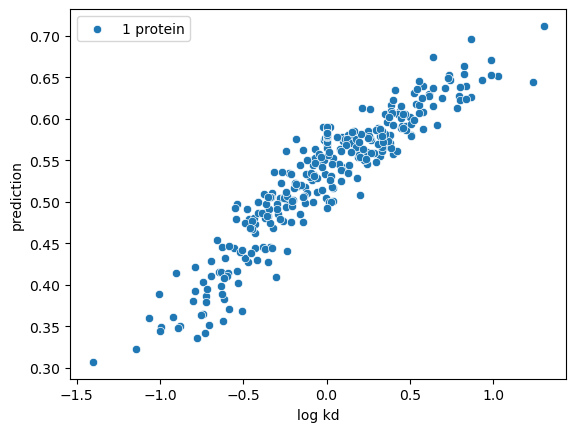

PearsonRResult(statistic=0.8931508238125032, pvalue=3.434379000185734e-140)
PearsonRResult(statistic=0.8931508238125032, pvalue=3.434379000185734e-140)


In [24]:
#two plots -log kd vs predictionZeroConc and predictionOneConc
sns.scatterplot(x=-np.log10(kds), y=predictionsZeroConc, label='0 protein', color='orange')
plt.xlabel('log kd')
plt.ylabel('prediction')
plt.show()
sns.scatterplot(x=-np.log10(kds), y=predictionsOneConc, label='1 protein')
plt.xlabel('log kd')
plt.ylabel('prediction')
plt.show()

#get correlation between predictions and kd values
from scipy.stats import pearsonr
print(pearsonr(-np.log(kds), predictionsZeroConc))
print(pearsonr(-np.log(kds), predictionsOneConc))


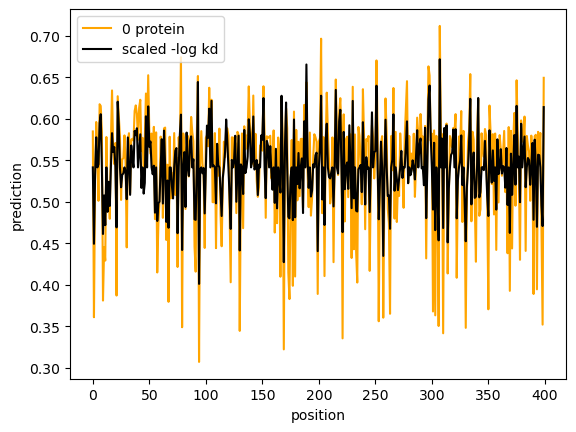

In [25]:
#lineplot of predictionsZeroConc
sns.lineplot(x=np.arange(0, len(predictionsZeroConc)), y=predictionsZeroConc, label='0 protein', color='orange')
#add (-log(kd) + mean)/variance of predictionsZeroConc

sns.lineplot(x=np.arange(0, len(predictionsZeroConc)), y=-np.log10(kds)/10+np.mean(predictionsZeroConc), label='scaled -log kd', color='black')
plt.xlabel('position')
plt.ylabel('prediction')
plt.show()

In [26]:
#save inferred probabilities for all protein concentration combinations

#initialize dictionary to store inferred probabilities
inferred_probs = {}

proteinConcentrations = [1,2,3,4]

#loop over protein concentrations
for protConc1 in proteinConcentrations:
    for protConc2 in proteinConcentrations:
        #create prediction example for current protein concentration combination and zeros for all kd values
        prediction_example = np.zeros((1, len(kds)+6))
        #insert protein concentration values at position 1 and 2
        prediction_example = np.insert(prediction_example, protConc2, 1)
        prediction_example = np.insert(prediction_example, protConc1, 1)
        
        #loop to set each position to 1 and infer probability
        predictions = []
        for i in range(8, len(kds)+8):
            current_prediction_example = prediction_example.copy()
            current_prediction_example[i] = 1
            current_prediction_example = torch.from_numpy(current_prediction_example).float()
            current_prediction_example = current_prediction_example.to(device)
            #output binding probability and append list for given protein concentration combination
            with torch.no_grad():
                output = model(current_prediction_example)
                predictions.append(output.item())
        #save inferred probabilities for given protein concentration combination
        inferred_probs[(protConc1, protConc2)] = predictions
            

In [27]:
#get variance of inferred probabilities for each protein concentration combination
variances = []
for protConc1 in proteinConcentrations:
    for protConc2 in proteinConcentrations:
        variances.append(np.var(inferred_probs[(protConc1, protConc2)]))

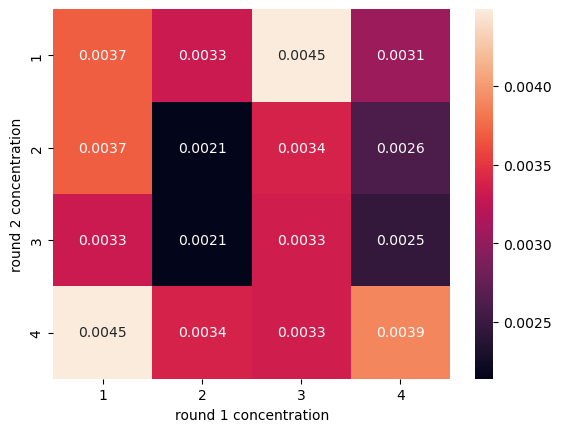

In [28]:
#plot variance of inferred probabilities for each protein concentration combination
sns.heatmap(np.array(variances).reshape(4,4), annot=True, xticklabels=proteinConcentrations, yticklabels=proteinConcentrations)
plt.xlabel('round 1 concentration')
plt.ylabel('round 2 concentration')
plt.show()

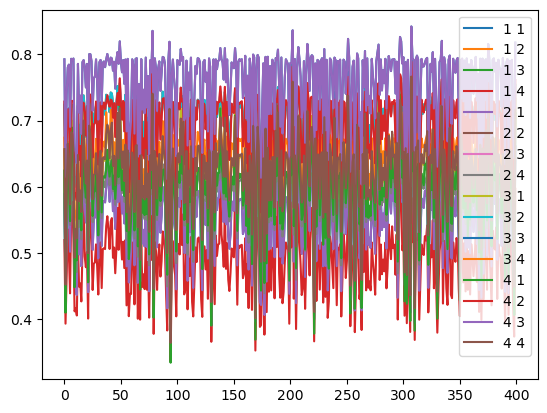

In [29]:
#plot inferred probabilities for each protein concentration combination
for protConc1 in proteinConcentrations:
    for protConc2 in proteinConcentrations:
        sns.lineplot(x=range(len(inferred_probs[(protConc1, protConc2)])), y=inferred_probs[(protConc1, protConc2)], label='{} {}'.format(protConc1, protConc2))

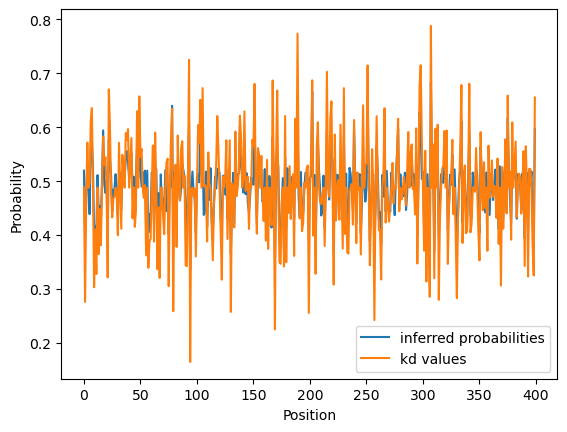

In [30]:
#plot predictions of highest variance protein concentration combination vs kd values
sns.lineplot(x=range(len(inferred_probs[(1,4)])), y=inferred_probs[(1,4)], label='inferred probabilities')
sns.lineplot(x=range(len(kds)), y=-np.log(kds)/10+np.mean(inferred_probs[(1,4)]), label='kd values')
plt.xlabel('Position')
plt.ylabel('Probability')
plt.show()

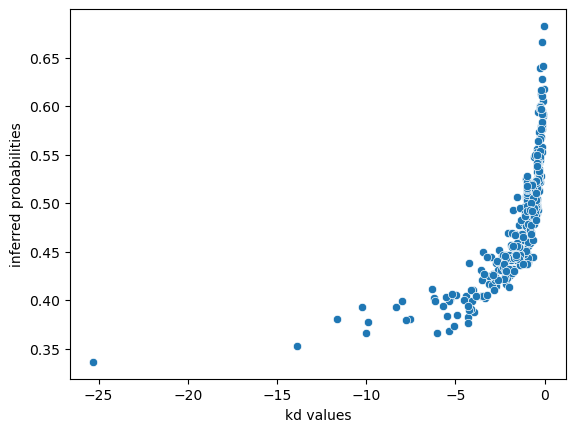

In [31]:
#scatter plot of inferred probabilities vs kd values
sns.scatterplot(x=-kds, y=inferred_probs[(1,4)])
plt.xlabel('kd values')
plt.ylabel('inferred probabilities')
plt.show()

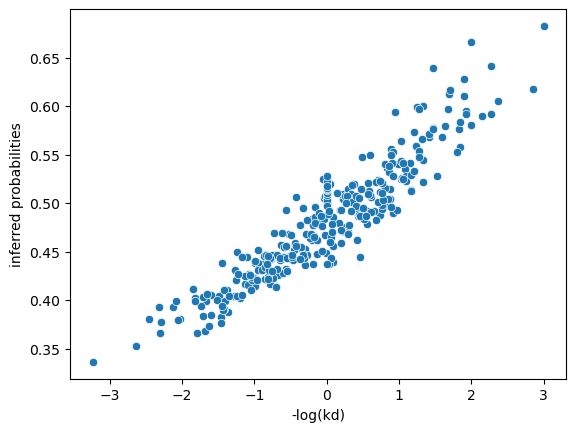

In [32]:
#scatterplot of negative log of kd values vs inferred probabilities
sns.scatterplot(x=-np.log(kds), y=inferred_probs[(1,4)])
plt.xlabel('-log(kd)')
plt.ylabel('inferred probabilities')
plt.show()

In [42]:
# read in oairwise kd values
pairwise_kds = np.loadtxt('/mnt/d/data/MIME_data/simData/dmMIME/seqLen100/fullEpistasis/secondFromProt1/prot1/pairwise_kds.txt')

pairwise_kds[0:10]


array([ 3.27339  ,  4.92388  , 17.1534   ,  2.80557  ,  0.278538 ,
        0.258434 ,  0.0952691,  0.0922604,  0.0397421, 14.3278   ])

In [34]:
import numpy as np
predictionsPairwise = []
prediction_example = np.zeros(len(X_train[0]))
for i in range(8, len(X_train[0]),4):
    for j in range(i+4, len(X_train[0]),4):
        for k in range(1,4):
            for l in range(1,4):
                    current_prediction_example = prediction_example.copy()
                    current_prediction_example[i+k] = 1
                    current_prediction_example[j+l] = 1
                    current_prediction_example = torch.from_numpy(current_prediction_example).float()
                    current_prediction_example = current_prediction_example.to(device)
                    #output binding probability and append list for given protein concentration combination
                    with torch.no_grad():
                        output = model(current_prediction_example)
                        predictionsPairwise.append(output.item())
                    print(i+k, j+l)


len(predictionsPairwise)


9 13
9 14
9 15
10 13
10 14
10 15
11 13
11 14
11 15
9 17
9 18
9 19
10 17
10 18
10 19
11 17
11 18
11 19
9 21
9 22
9 23
10 21
10 22
10 23
11 21
11 22
11 23
9 25
9 26
9 27
10 25
10 26
10 27
11 25
11 26
11 27
9 29
9 30
9 31
10 29
10 30
10 31
11 29
11 30
11 31
9 33
9 34
9 35
10 33
10 34
10 35
11 33
11 34
11 35
9 37
9 38
9 39
10 37
10 38
10 39
11 37
11 38
11 39
9 41
9 42
9 43
10 41
10 42
10 43
11 41
11 42
11 43
9 45
9 46
9 47
10 45
10 46
10 47
11 45
11 46
11 47
9 49
9 50
9 51
10 49
10 50
10 51
11 49
11 50
11 51
9 53
9 54
9 55
10 53
10 54
10 55
11 53
11 54
11 55
9 57
9 58
9 59
10 57
10 58
10 59
11 57
11 58
11 59
9 61
9 62
9 63
10 61
10 62
10 63
11 61
11 62
11 63
9 65
9 66
9 67
10 65
10 66
10 67
11 65
11 66
11 67
9 69
9 70
9 71
10 69
10 70
10 71
11 69
11 70
11 71
9 73
9 74
9 75
10 73
10 74
10 75
11 73
11 74
11 75
9 77
9 78
9 79
10 77
10 78
10 79
11 77
11 78
11 79
9 81
9 82
9 83
10 81
10 82
10 83
11 81
11 82
11 83
9 85
9 86
9 87
10 85
10 86
10 87
11 85
11 86
11 87
9 89
9 90
9 91
10 89
10 90
10 9

44550

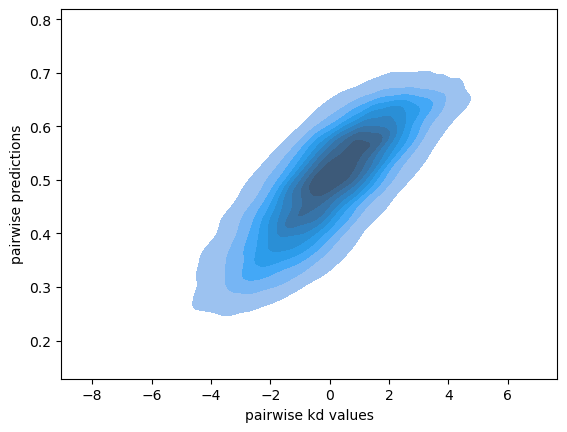

In [44]:
#density plot pairwise predictions vs pairwise kd values
sns.kdeplot(x=-np.log(pairwise_kds), y=predictionsPairwise, fill=True)
plt.xlabel('pairwise kd values')
plt.ylabel('pairwise predictions')
plt.show()

In [45]:
#get correlation between pairwise predictions and pairwise kd values
from scipy.stats import pearsonr
print(pearsonr(-np.log(pairwise_kds), predictionsPairwise))

PearsonRResult(statistic=0.7768942248035476, pvalue=0.0)


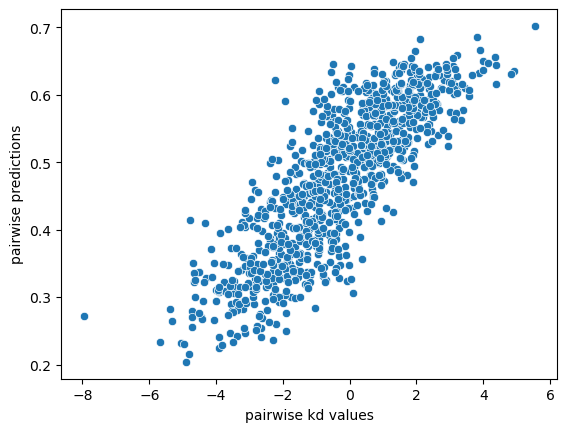

In [48]:
#plot pairwise predictions vs pairwise kd values
sns.scatterplot(x=-np.log(pairwise_kds)[0:1000], y=predictionsPairwise[0:1000])
plt.xlabel('pairwise kd values')
plt.ylabel('pairwise predictions')
plt.show()